In [37]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)
classes=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','0','12','3','4','5','6','7','8','9']


Found 1452 images belonging to 35 classes.
Found 363 images belonging to 35 classes.


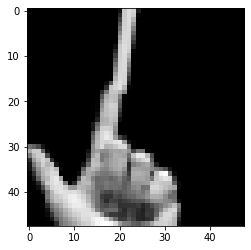

In [68]:
img_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20.0,
    width_shift_range=20.0,
    height_shift_range=20.0,
    shear_range=0.1,
    zoom_range=.1,
    channel_shift_range=0.0,
    fill_mode='nearest',
    horizontal_flip=True,
    # vertical_flip=True,
    validation_split=0.2    
    
)

train_generator = img_generator.flow_from_directory(
  './asl_dataset',
  target_size=(48,48),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
  subset='training'
)

val_generator = img_generator.flow_from_directory(
  './asl_dataset',
  target_size=(48,48),
  color_mode='grayscale',
  classes=classes,
  class_mode='categorical',
  seed=SEED,
  shuffle=False,
  subset='validation'
)

for i, image in enumerate(val_generator):
  if i == 5:
    plt.imshow(image[0][1], cmap = 'gray')
    break



In [70]:
input = keras.Input(shape=(48, 48, 1))
layer1 = tf.keras.layers.Conv2D(16, (2,2), activation= 'relu', name="layer1")
layer2 = tf.keras.layers.MaxPool2D(2,2, name="layer2")
layer3 = tf.keras.layers.Flatten(name="layer3")
layer4 = tf.keras.layers.Dense(64, activation='relu', name='layer4')
layer5 = tf.keras.layers.Dense(128, activation='relu', name='layer5')
layer6 = tf.keras.layers.Dense(128, activation='relu', name='layer6')

output =  tf.keras.layers.Dense(len(classes), activation='sigmoid', name='symbol')

network = output(layer6(layer5(layer4(layer3(layer2(layer1(input)))))))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model = tf.keras.Model(inputs=input, outputs=network, name="Logan")


model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              loss_weights=[0.5],
              metrics=[tf.keras.metrics.top_k_categorical_accuracy],
              )


early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
# checkpoints = keras.callbacks.ModelCheckpoint(
#     filepath=check_dir,
#     monitor='val_loss',
#     save_best_only=True,
#     save_weights_only=False
# )
# tensorboard = keras.callbacks.TensorBoard(
#     log_dir=tboard_dir
# )
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

callbacks = [early_stop, reduce_lr]

# fit the model with training and validation generators
# In addition please specify the following arguments
# steps_per_epoch=len(df_train)/batch_size
# validation_steps=len(df_val)/batch_size
# (5)
print(model.summary())
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False)
model.fit(
        train_generator,
        epochs=15,
        validation_data=val_generator,
        batch_size=8, 
        callbacks=callbacks,
        # steps_per_epoch=len(train)/batch_size,
        # validation_steps=len(val)/batch_size
        )




Model: "Logan"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 layer1 (Conv2D)             (None, 47, 47, 16)        80        
                                                                 
 layer2 (MaxPooling2D)       (None, 23, 23, 16)        0         
                                                                 
 layer3 (Flatten)            (None, 8464)              0         
                                                                 
 layer4 (Dense)              (None, 64)                541760    
                                                                 
 layer5 (Dense)              (None, 128)               8320      
                                                                 
 layer6 (Dense)              (None, 128)               16512 